In [2]:
# Library imports (see /Utilities/setup_env.py for full import list and figure setup)

from pathlib import Path
import sys

repo_root = Path.cwd().parents[0]  # .../Figure_analysis
repo_root = repo_root.parent       # repo root
sys.path.insert(0, str(repo_root))

from Figure_analysis.Utilities.setup_env import *

### Fetch data from nerd sqlite database

In [36]:
def fetch_fit_params(db_path, fit_kind, selected_construct_names, selected_temperature=None):
    """
    Fetch fit parameters from the database for a given fit kind, construct name(s),
    and optionally temperature.

    If selected_temperature is None, all temperatures are returned.
    """

    conn = sqlite3.connect(db_path)

    placeholders = ", ".join([f":construct_{i}" for i in range(len(selected_construct_names))])
    params = {
        "fit_kind": fit_kind,
        **{f"construct_{i}": name for i, name in enumerate(selected_construct_names)},
    }

    # conditionally add temperature clause
    temp_clause = ""
    if selected_temperature is not None:
        temp_clause = "AND temperature = :temperature"
        params["temperature"] = selected_temperature

    fit_params_df = pd.read_sql_query(
        f"""
        SELECT
            log_kobs,
            log_kdeg,
            r2,
            nt_base,
            nt_site,
            construct_name,
            rg_id,
            temperature
        FROM probe_tc_fits_view
        WHERE fit_kind = :fit_kind
          AND construct_name IN ({placeholders})
          {temp_clause}
        """,
        conn,
        params=params,
    )

    conn.close()
    return fit_params_df

### Main function definition and execution

1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


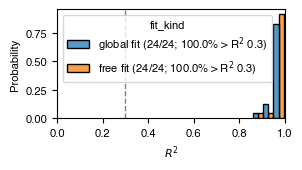

In [71]:
NERD_SQLITE = '../../Core_nerd_analysis/nerd.sqlite'

# --- fetch (as you already do) ---
df_global = fetch_fit_params(
    db_path=NERD_SQLITE,
    fit_kind='round3_constrained',
    selected_construct_names=['4U_wt'],
    selected_temperature=25,
)
df_free = fetch_fit_params(
    db_path=NERD_SQLITE,
    fit_kind='round1_free',
    selected_construct_names=['4U_wt'],
    selected_temperature=25,
)

# --- filter out outliers consistently ---
exclude_rg = [10, 32]
df_global = df_global[~df_global['rg_id'].isin(exclude_rg)].copy()
df_free   = df_free[~df_free['rg_id'].isin(exclude_rg)].copy()

# filter A/C sites only
df_global = df_global[df_global['nt_base'].isin(['A', 'C'])].copy()
df_free   = df_free[df_free['nt_base'].isin(['A', 'C'])].copy()

# calculate xx/yy (%) above R2 > 0.3 then annotate in label
df_global_above_03 = (df_global['r2'] > 0.3).sum()
df_free_above_03   = (df_free['r2'] > 0.3).sum()
df_global_total    = len(df_global)
df_free_total      = len(df_free)  
df_global_perc = df_global_above_03 / df_global_total * 100
df_free_perc   = df_free_above_03 / df_free_total * 100

# --- keep only what you need + label ---
df_global["fit_kind"] = fr"global fit ({df_global_above_03}/{df_global_total}; {df_global_perc:.1f}% > R$^2$ 0.3)"
df_free["fit_kind"]   = fr"free fit ({df_free_above_03}/{df_free_total}; {df_free_perc:.1f}% > R$^2$ 0.3)"

r2_df = pd.concat(
    [df_global[["r2", "fit_kind"]], df_free[["r2", "fit_kind"]]],
    ignore_index=True
).dropna(subset=["r2"])

# --- plot: overlaid histograms (clean + compact) ---
fig, ax = plt.subplots(figsize=(3, 1.75))
sns.histplot(
    data=r2_df,
    x="r2",
    hue="fit_kind",
    bins=3,
    stat="probability",      # or "count"
    common_norm=False,   # each curve normalized independently (usually what you want)
    element="bars",
    multiple="dodge",
    ax=ax,
)
# vertical line at R2 = 0.3
ax.axvline(x=0.3, color='gray', linestyle='--', linewidth = 1)
ax.set_xlabel(r"$R^2$")
ax.set_ylabel("Probability")
ax.set_xlim(0, 1)
plt.tight_layout()
plt.savefig("r2_distribution_25C.pdf")
plt.show()


1 extra bytes in post.stringData array
'created' timestamp seems very low; regarding as unix timestamp


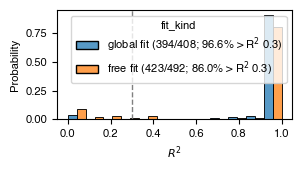

In [68]:
NERD_SQLITE = '../../Core_nerd_analysis/nerd.sqlite'

# --- fetch (as you already do) ---
df_global = fetch_fit_params(
    db_path=NERD_SQLITE,
    fit_kind='round3_constrained',
    selected_construct_names=['4U_wt'],
    selected_temperature=None,
)
df_free = fetch_fit_params(
    db_path=NERD_SQLITE,
    fit_kind='round1_free',
    selected_construct_names=['4U_wt'],
    selected_temperature=None,
)

# --- filter out outliers consistently ---
exclude_rg = [10, 32]
df_global = df_global[~df_global['rg_id'].isin(exclude_rg)].copy()
df_free   = df_free[~df_free['rg_id'].isin(exclude_rg)].copy()

# filter A/C sites only
df_global = df_global[df_global['nt_base'].isin(['A', 'C'])].copy()
df_free   = df_free[df_free['nt_base'].isin(['A', 'C'])].copy()

# calculate xx/yy (%) above R2 > 0.3 then annotate in label
df_global_above_03 = (df_global['r2'] > 0.3).sum()
df_free_above_03   = (df_free['r2'] > 0.3).sum()
df_global_total    = len(df_global)
df_free_total      = len(df_free)  
df_global_perc = df_global_above_03 / df_global_total * 100
df_free_perc   = df_free_above_03 / df_free_total * 100

# --- keep only what you need + label ---
df_global["fit_kind"] = fr"global fit ({df_global_above_03}/{df_global_total}; {df_global_perc:.1f}% > R$^2$ 0.3)"
df_free["fit_kind"]   = fr"free fit ({df_free_above_03}/{df_free_total}; {df_free_perc:.1f}% > R$^2$ 0.3)"

r2_df = pd.concat(
    [df_global[["r2", "fit_kind"]], df_free[["r2", "fit_kind"]]],
    ignore_index=True
).dropna(subset=["r2"])

# --- plot: overlaid histograms (clean + compact) ---
fig, ax = plt.subplots(figsize=(3, 1.75))
sns.histplot(
    data=r2_df,
    x="r2",
    hue="fit_kind",
    bins=12,
    stat="probability",      # or "count"
    common_norm=False,   # each curve normalized independently (usually what you want)
    element="bars",
    multiple="dodge",
    ax=ax,
)

# vertical line at R2 = 0.3
ax.axvline(x=0.3, color='gray', linestyle='--', linewidth = 1)

ax.set_xlabel(r"$R^2$")
ax.set_ylabel("Probability")
plt.tight_layout()
plt.savefig("r2_distribution_alltemps.pdf")
plt.show()
